<div style="text-align:center; color:  #13476a ; font-size:20px">

<h1> Word2Vec  </h1> 

Alejandro Fandiño B
    
</div>

Expectativas:

- Uso de Word2Vec
- Responder:
    - ¿Su modelo da buenos resultados? ¿Por qué sí o por qué no?
    - ¿Qué problemas encontró al realizar este taller?

Algunas ideas:

- Hacer más visualizaciones
- Jugar con los parámetros de la funcion word2vec de gensim
- Usar alguna función de gensim que no hayamos visto en clase (https://radimrehurek.com/gensim/models/word2vec.html#module-gensim.models.word2vec)

- Comparar palabras del inglés y el español
- Encontrar analogías y similutdes interesantes


In [1]:
import re
import numpy as np
import pandas as pd

from nltk.corpus import stopwords
stopwords_sp = stopwords.words('spanish')

from nltk.stem.snowball import SnowballStemmer
spanishStemmer=SnowballStemmer("spanish")

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [10]:
rap = pd.read_csv("archivos/rap_espanol.csv")
rap.head()

id           artista                                            cancion  \
0   0             Denom             Machete (con Jarfaiter y Gente jodida)   
1   1             Denom                           Vacío (con Ivo Incuerdo)   
2   2             Denom  El orgullo es fiel (con Juancho Marqués y Elio...   
3   3             Denom                    Mueve mueve (con Fernandocosta)   
4   4  Jaro Desperdizio                                           Insomnia   

                           album  \
0                       Medicina   
1                       Medicina   
2                       Medicina   
3                       Medicina   
4  Sin álbum, es un vídeo suelto   

                                               letra  anyo  visitas  
0  Para su nuevo disco "Medicina", Denom ha vuelt...  2019      126  
1  [Denom]\nYo que quería, yo que pedía vida,\nSe...  2019      361  
2  "El orgullo es fiel" es uno de los cortes incl...  2019      262  
3  [Estribillo: Denom] (x2)\nMueve, mueve, mueve,...  2019      578  
4  [Estribillo]\nY en esta noche, ¿Quién me arrop...  2019      219

In [11]:
def pre_procesado(texto):
    texto = texto.lower()
    texto = re.sub(r"[\W\d_]+", " ", texto)
    texto = " ".join([palabra for palabra in texto.split() if palabra not in stopwords_sp])
    return texto

In [12]:
rap['pp'] = rap['letra'].apply(lambda texto: pre_procesado(texto))
rap.head()

id           artista                                            cancion  \
0   0             Denom             Machete (con Jarfaiter y Gente jodida)   
1   1             Denom                           Vacío (con Ivo Incuerdo)   
2   2             Denom  El orgullo es fiel (con Juancho Marqués y Elio...   
3   3             Denom                    Mueve mueve (con Fernandocosta)   
4   4  Jaro Desperdizio                                           Insomnia   

                           album  \
0                       Medicina   
1                       Medicina   
2                       Medicina   
3                       Medicina   
4  Sin álbum, es un vídeo suelto   

                                               letra  anyo  visitas  \
0  Para su nuevo disco "Medicina", Denom ha vuelt...  2019      126   
1  [Denom]\nYo que quería, yo que pedía vida,\nSe...  2019      361   
2  "El orgullo es fiel" es uno de los cortes incl...  2019      262   
3  [Estribillo: Denom] (x2)\nMueve, mueve, mueve,...  2019      578   
4  [Estribillo]\nY en esta noche, ¿Quién me arrop...  2019      219   

                                                  pp  
0  nuevo disco medicina denom vuelto contar colab...  
1  denom quería pedía vida partió mitad ahora fri...  
2  orgullo fiel cortes incluidos nuevo disco deno...  
3  estribillo denom x mueve mueve mueve tiempo pe...  
4  estribillo noche quién arropará si invierno in...

In [13]:
sent = [row.split() for row in rap['pp'].values]

In [14]:
sent

[['nuevo',
  'disco',
  'medicina',
  'denom',
  'vuelto',
  'contar',
  'colaboración',
  'vocal',
  'jarfaiter',
  'quién',
  'colaborado',
  'anteriormente',
  'tema',
  'machete',
  'corte',
  'tambien',
  'participa',
  'grupo',
  'gente',
  'jodida',
  'instrumental',
  'encarga',
  'narcosbeats',
  'letra',
  'tema',
  'ayúdanos',
  'envíanosla'],
 ['denom',
  'quería',
  'pedía',
  'vida',
  'partió',
  'mitad',
  'ahora',
  'frio',
  'siento',
  'dentro',
  'dolor',
  'tragos',
  'colonia',
  'principios',
  'histeria',
  'color',
  'elija',
  'llorar',
  'aunque',
  'sonría',
  'sabes',
  'sufrir',
  'si',
  'amar',
  'perderías',
  'sé',
  'guardar',
  'solo',
  'recuerdos',
  'aun',
  'así',
  'fumo',
  'jodo',
  'luego',
  'vengas',
  'llorar',
  'escribo',
  'solo',
  'aunque',
  'pensando',
  'ojos',
  'rojos',
  'llorar',
  'mano',
  'polla',
  'problemas',
  'collares',
  'epopeya',
  'dejes',
  'destruya',
  'freya',
  'estribillo',
  'denom',
  'x',
  'si',
  'aquí',

In [15]:
# Se crea un bigrams para las palabras comunes
from gensim.models.phrases import Phrases, Phraser
phrases = Phrases(rap['pp'].values, min_count=30, progress_per=10000)

bigram = Phraser(phrases)
sentences = bigram[sent]

In [16]:
# Frecuencia de palabras
from sklearn.feature_extraction.text import CountVectorizer

count_vect = CountVectorizer()
bow_rep = count_vect.fit_transform(rap['pp'].values)

In [17]:
len(count_vect.vocabulary_)

117589

# MODELO 

In [18]:
import gensim.models.word2vec as w2v

In [24]:
%%time
# Un modelo con el array de datos rap['pp']
mi_modelo = w2v.Word2Vec(sent,
                         sg=1, # 1 skip-gram. 0 CBOW
                         seed=1, # semilla
                         size=256, # número de dimensiones
                         min_count=150,
                         window=12)

Wall time: 49.2 s


In [25]:
# Modelo con entrada de las bigrams
mi_modelo2 = w2v.Word2Vec(sentences,
                          sg=1, # 1 skip-gram. 0 CBOW
                          seed=1, # semilla
                          size=300, # número de dimensiones
                          min_count=20,
                          min_alpha=0.0007,
                          window=2)

In [23]:
# Veamos que nos da en comparacion:
mi_modelo.wv.most_similar(positive=["gente"])

[('miente', 0.42831656336784363),
 ('presidente', 0.42483294010162354),
 ('personas', 0.4240434467792511),
 ('diferente', 0.42075079679489136),
 ('enfrente', 0.41600751876831055),
 ('diferentes', 0.41049960255622864),
 ('siempre', 0.405191034078598),
 ('corriente', 0.4044637680053711),
 ('pendiente', 0.3944396376609802),
 ('valiente', 0.39005163311958313)]

In [26]:
mi_modelo.wv.similarity("gente", 'grupo')

0.22049183

In [27]:
# Ahora con el bigrama:
mi_modelo2.wv.most_similar(positive=["gente"])

[('peña', 0.6190724968910217),
 ('confusión', 0.5247814655303955),
 ('calaña', 0.5206015110015869),
 ('posicion', 0.511618971824646),
 ('constantemente', 0.5116121768951416),
 ('información', 0.5087543725967407),
 ('hipocresía', 0.5019742250442505),
 ('indiferente', 0.49513569474220276),
 ('guasa', 0.49190667271614075),
 ('peñita', 0.4894041419029236)]

In [28]:
mi_modelo2.wv.similarity("gente", 'grupo')

0.29819036

Hay una difencia entre el modelo 1 y el modelo 2, aún más vemos que en el modelo la palabra gente tiene mas similitud a miente, por otro lado,


In [30]:
mi_modelo.init_sims(replace=True)

In [32]:
# aquí, le pedimos a nuestro modelo que nos dé la palabra que no pertenece a la lista.
mi_modelo.wv.doesnt_match(['gente', 'pueblo', 'raza'])

C:\Users\ALEJANDRO\anaconda3\lib\site-packages\gensim\models\keyedvectors.py:877: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  vectors = vstack(self.word_vec(word, use_norm=True) for word in used_words).astype(REAL)


'raza'

In [33]:
mi_modelo2.wv.doesnt_match(['gente', 'pueblo', 'raza'])

'gente'

# Gráfico

In [23]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
 
import seaborn as sns
sns.set_style("darkgrid")

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [36]:
# CREAR MATRIX CPA

X = mi_modelo[mi_modelo.wv.vocab]
matrix = pd.DataFrame(X)
matrix.index = mi_modelo.wv.vocab.keys()

matrix

<ipython-input-36-0f6f68f3e37d>:3: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  X = mi_modelo[mi_modelo.wv.vocab]


0         1         2         3         4         5         6    \
n -0.048915  0.157523 -0.050486  0.111330 -0.005162  0.051257  0.046972   
u -0.010124  0.227561 -0.107590  0.102154  0.052935  0.109413  0.140595   
e -0.048217  0.142450 -0.068525  0.037969 -0.004343  0.051961  0.213606   
v -0.097218  0.190354 -0.041603  0.097969 -0.093550  0.125579  0.204819   
o -0.060210  0.209291 -0.099988  0.112195  0.038481  0.053488  0.127235   
  -0.048045  0.220553 -0.105956  0.137687  0.029240  0.050219  0.154387   
d  0.003561  0.095749 -0.073177  0.071773 -0.033958  0.119465  0.082001   
i -0.090583  0.173272 -0.044253  0.088664 -0.005304  0.035488  0.132066   
s -0.035837  0.186014 -0.106957  0.092734  0.008669  0.087227  0.127642   
c -0.071069  0.181057 -0.097734  0.086931  0.012117  0.051506  0.123220   
m -0.077672  0.142559 -0.055852  0.071988 -0.002388  0.052117  0.097468   
a -0.073536  0.172513 -0.105659  0.036620  0.086116  0.085662  0.158642   
l -0.072479  0.225139 -0.100667  0.129576 -0.007148  0.100139  0.092239   
t -0.060202  0.127300 -0.022595  0.066699 -0.010514 -0.006279  0.120604   
r  0.003462  0.165312 -0.092093  0.104966  0.026129  0.078042  0.073778   
b -0.090502  0.194195 -0.100846  0.090369 -0.009769  0.024240  0.086159   
ó -0.085222  0.262207 -0.140270  0.132652  0.064650 -0.000349 -0.013593   
j  0.015933  0.092209 -0.099914  0.049780 -0.041473  0.065005  0.143614   
f -0.130782  0.190363 -0.020844  0.139664  0.042535 -0.065479  0.023657   
q -0.021145  0.213128 -0.262547  0.082477 -0.092001  0.159019  0.049413   
é -0.044154  0.278682 -0.228201  0.114709 -0.087366  0.125195  0.109026   
h -0.086665  0.210843 -0.179303  0.097189 -0.023607  0.007890  0.071646   
p -0.091087  0.167625 -0.076158  0.069090 -0.002860  0.001992  0.047594   
g -0.096247  0.127118  0.008336  0.062155  0.021212  0.058346  0.027320   
y -0.001373  0.064521  0.034133  0.044711 -0.086600  0.088329  0.213946   
ú -0.369235  0.271186 -0.036442  0.095365  0.072946  0.050512  0.039981   
í -0.057615  0.221214 -0.111532  0.116288 -0.069252  0.153894  0.140506   
x -0.193120  0.370231 -0.029496  0.195869 -0.047950 -0.093624  0.024407   
á -0.245186  0.144583 -0.165808  0.006436  0.108845  0.010299  0.070809   
z -0.175251  0.282354 -0.087262  0.114230  0.018697  0.015058  0.214885   
ñ -0.047859  0.337164 -0.261640  0.106373 -0.094360  0.181852  0.188598   
k -0.033945  0.044817  0.126815  0.055020  0.022273 -0.004880  0.182843   
w  0.198984 -0.275642  0.370432  0.002867  0.090396 -0.043911  0.074115   
ò  0.328607 -0.104491 -0.032373 -0.043335 -0.127900  0.109451  0.111596   
ü -0.286822  0.303200 -0.048076  0.188207 -0.136197  0.070808  0.464739   
ç  0.195224  0.022210 -0.326839  0.014559 -0.199473  0.133533  0.225505   
à  0.274827 -0.053003  0.006024 -0.013017 -0.066591 -0.027168  0.254402   
è  0.192104  0.002217 -0.022418 -0.092255 -0.044058  0.004237  0.358401   
ã  0.128216  0.022716 -0.166571 -0.079893 -0.306919  0.344789  0.247394   

        7         8         9    ...       246       247       248       249  \
n -0.162400 -0.019693 -0.032444  ... -0.056912  0.018827 -0.022044 -0.020901   
u -0.160990  0.046963  0.032473  ... -0.030345  0.068356  0.028169 -0.082020   
e -0.174051  0.011941  0.023380  ... -0.039889  0.035323 -0.046402 -0.042918   
v -0.186540 -0.020580  0.031622  ... -0.028700 -0.004302 -0.107502  0.009124   
o -0.158183 -0.010334  0.013300  ... -0.043198  0.030539 -0.010436 -0.040154   
  -0.198081 -0.023056 -0.026102  ... -0.038863  0.009836 -0.050101  0.029924   
d -0.132804 -0.007153 -0.012886  ... -0.059586  0.012388 -0.019526 -0.016927   
i -0.155688 -0.018922 -0.024335  ... -0.059154  0.033773 -0.067261 -0.013764   
s -0.186861  0.014703  0.015780  ... -0.056996  0.019829 -0.021221 -0.003479   
c -0.178003 -0.006024  0.017956  ... -0.065711 -0.005343 -0.016274  0.001829   
m -0.138050  0.016969 -0.001942  ... -0.061306  0.023872 -0.008306 -0.026367   
a -0.180697 -0.011362  0.025543  ... -0.061470 

In [75]:
reduc = PCA(n_components=30).fit_transform(matrix)       

In [76]:
Y = TSNE(n_components=2, random_state=0, perplexity=15).fit_transform(reduc)
result = pd.DataFrame(Y)
result.columns = ['X', 'Y']
result

X           Y
0    63.733284  -10.227693
1   -52.123699   29.367754
2   -17.643642   16.512869
3    12.209035   83.754837
4   -31.488583   -7.078500
5    42.226280  -34.934738
6    13.005270   14.584594
7    44.620064   12.905056
8     0.019926   -9.065452
9    77.292046  -38.001450
10   13.164758  -32.553894
11  -51.388966  -32.646187
12   30.855244   43.858913
13   29.490557  -10.288986
14  -16.532070  -33.619854
15   58.934380   53.163826
16  114.193222  -25.265717
17  -28.084913  -74.698601
18   85.622864   17.793556
19  -58.166512   74.957695
20   57.420692  107.018677
21  -12.350814   52.397507
22    7.759410  -58.383003
23   44.670204  -67.226463
24   12.305049 -112.609756
25  133.830688   27.470760
26  -75.305946  -68.001106
27  121.674576  -73.827423
28 -103.350685   39.592464
29  -97.944870  -20.134144
30   71.608627 -108.335739
31  -22.140451 -134.925659
32   -2.796889 -160.942551
33   13.379746  199.416107
34 -128.673447  -29.751438
35  -30.891047  179.154297
36    0.296972  178.234497
37  -11.242011  204.535507
38  -53.337032  168.323074

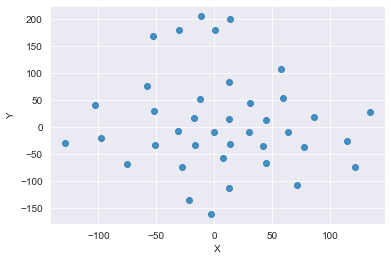

In [46]:
 p1 = sns.regplot(data=result,
                     x="X",
                     y="Y",
                     fit_reg=False,
                     marker="o",
                    )